### Importing all the libraries needed.

In [1]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist, fashion_mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### Loading the dataset and splitting them into training and testing.

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
print('Training Data Shape: ', X_train.shape, y_train.shape)
print('Testing Data Shape: ', X_test.shape, y_test.shape)

Training Data Shape:  (60000, 28, 28) (60000,)
Testing Data Shape:  (10000, 28, 28) (10000,)


### We have to reshape our dataset because we are going to work with PCA.

In [4]:
# X_train = X_train.reshape(-1, 28, 28, 1)
# X_test = X_test.reshape(-1, 28, 28, 1)
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)
# X_train = X_train.reshape(-1, 784, 1)
# X_test = X_test.reshape(-1, 784, 1)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


print('Training Data Shape: ', X_train.shape, y_train.shape)
print('Testing Data Shape: ', X_test.shape, y_test.shape)

Training Data Shape:  (60000, 784) (60000,)
Testing Data Shape:  (10000, 784) (10000,)


### PCA using 95% variance.

In [5]:
pca = PCA(0.95) # 95% Variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print('Training Data Shape: ', X_train_pca.shape, y_train.shape)
print('Testing Data Shape: ', X_test_pca.shape, y_test.shape)

Training Data Shape:  (60000, 188) (60000,)
Testing Data Shape:  (10000, 188) (10000,)


### Right now the dataset is in the format of int8 so we have to convert it to float32 before feeding it into the model. After that we are going to scale the value from 0 - 1 by dividing by 255.

In [6]:
X_train_pca = X_train_pca.astype('float32')
X_test_pca = X_test_pca.astype('float32')
X_train_pca = X_train_pca / 255
X_test_pca = X_test_pca / 255

### Next, we are going to one hot encode the y_train and y_test using the to_categorical function.

In [7]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Test Print
y_test_encoded

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Reshaping the dataset so it could be feeded into Conv1D layers.

In [8]:
X_train_pca = X_train_pca.reshape(-1, 188, 1)
X_test_pca = X_test_pca.reshape(-1, 188, 1)

In [9]:
X_train_pca.shape, X_test_pca.shape

((60000, 188, 1), (10000, 188, 1))

### Now, we are going to split the training dataset into training and validation dataset. I have divided train and validation into 80 20 respectively.

In [10]:
X_train_pca, X_valid, train_label, valid_label = train_test_split(X_train_pca, y_train_encoded, test_size=0.2, random_state=13)

In [11]:
X_train_pca.shape, X_valid.shape, train_label.shape, valid_label.shape

((48000, 188, 1), (12000, 188, 1), (48000, 10), (12000, 10))

### This will be the part where modelling the data starts. I have used the batch size of 64 and 20 epochs.

In [23]:
batch_size = 64
epochs = 40

### First we add our first convolutional layer using Conv1D. We are using Conv1D here because we are dealing with non-image dataset. Next we add the LeakyReLU because it's going to help the network learn non-linear decision boundary. Next would be the MaxPooling1D layer and then the last layer would be the Dense layer using the softmax function. After that would be the Dropout layer which helps us avoiding the problem of overfitting. 

In [24]:
fashion_model = Sequential()
fashion_model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(400, 1), padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling1D(2, padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling1D(2, padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling1D(2, padding='same'))
fashion_model.add(Dropout(0.4))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='relu'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(Dropout(0.3))
fashion_model.add(Dense(10, activation='softmax'))

### Now we are going to compile our model that we just made using Adam Optimizer as the optimizer and Categorical CrossEntropy as the loss function which is often used as a loss function for multi-class classification.

In [25]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

### Now we fit the model.

In [26]:
fashion_train = fashion_model.fit(X_train_pca, train_label, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_valid, valid_label))

Epoch 1/40
750/750 [==============================] - 40s 52ms/step - loss: 1.6505 - accuracy: 0.3791 - val_loss: 0.9777 - val_accuracy: 0.6581
Epoch 2/40
750/750 [==============================] - 39s 53ms/step - loss: 0.9594 - accuracy: 0.6493 - val_loss: 0.6944 - val_accuracy: 0.7586
Epoch 3/40
750/750 [==============================] - 39s 53ms/step - loss: 0.7894 - accuracy: 0.7119 - val_loss: 0.5939 - val_accuracy: 0.7870
Epoch 4/40
750/750 [==============================] - 39s 52ms/step - loss: 0.7078 - accuracy: 0.7411 - val_loss: 0.5662 - val_accuracy: 0.7942
Epoch 5/40
750/750 [==============================] - 40s 53ms/step - loss: 0.6593 - accuracy: 0.7591 - val_loss: 0.5380 - val_accuracy: 0.8031
Epoch 6/40
750/750 [==============================] - 39s 53ms/step - loss: 0.6292 - accuracy: 0.7710 - val_loss: 0.4873 - val_accuracy: 0.8194
Epoch 7/40
750/750 [==============================] - 39s 52ms/step - loss: 0.6000 - accuracy: 0.7830 - val_loss: 0.4817 - val_accuracy:

In [27]:
fashion_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_10 (ModuleWra (None, 188, 32)           128       
_________________________________________________________________
module_wrapper_11 (ModuleWra (None, 188, 32)           0         
_________________________________________________________________
module_wrapper_12 (ModuleWra (None, 94, 32)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 94, 32)            0         
_________________________________________________________________
module_wrapper_13 (ModuleWra (None, 94, 64)            6208      
_________________________________________________________________
module_wrapper_14 (ModuleWra (None, 94, 64)            0         
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 47, 64)           

### We evaluate the model to see how our model works on the testing dataset. The results that I've got is quite impressive. The total loss is 0.3680 and the accuracy of 0.8643.

In [28]:
evaluation = fashion_model.evaluate(X_test_pca, y_test_encoded, verbose=1)

313/313 [==============================] - 3s 8ms/step - loss: 0.3680 - accuracy: 0.8643


In [29]:
print('Test Loss: ', evaluation[0])
print('Test Accuracy: ', evaluation[1])

Test Loss:  0.36799177527427673
Test Accuracy:  0.864300012588501


### Now let's plot the loss and accuracy plots for training and validation to see the results visually.

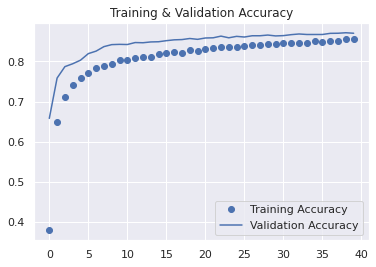

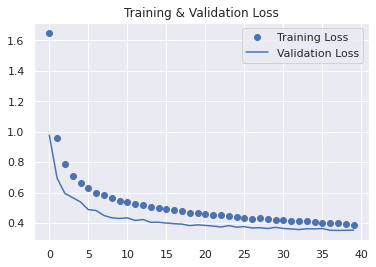

In [30]:
accuracy = fashion_train.history['accuracy']
val_accuracy = fashion_train.history['val_accuracy']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

### Now it's the time for prediction. We have a 87% of accuracy.

In [31]:
predicted = fashion_model.predict(X_test_pca)
predicted = np.argmax(np.round(predicted), axis=1)

In [32]:
from sklearn.metrics import classification_report
class_number = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_test, predicted, target_names=class_number))

              precision    recall  f1-score   support

     Class 0       0.56      0.92      0.69      1000
     Class 1       1.00      0.96      0.98      1000
     Class 2       0.81      0.74      0.77      1000
     Class 3       0.90      0.86      0.88      1000
     Class 4       0.81      0.75      0.78      1000
     Class 5       0.98      0.91      0.94      1000
     Class 6       0.79      0.49      0.60      1000
     Class 7       0.90      0.96      0.93      1000
     Class 8       0.96      0.96      0.96      1000
     Class 9       0.95      0.94      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.87      0.85      0.85     10000
weighted avg       0.87      0.85      0.85     10000



### Here we visualize the correct predictions made by the model.

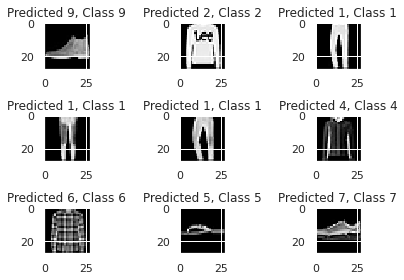

In [33]:
correct = np.where(predicted==y_test)[0]

for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted[correct], y_test[correct]))
    plt.tight_layout()